In [1]:
import pandas as pd
import numpy as npa

import yfinance as yf
import yahoo_fin.stock_info as si

from tqdm import tqdm

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from xgboost import XGBRegressor

from gtda.time_series import TakensEmbedding, SlidingWindow

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Inspired by https://docs.google.com/presentation/d/1WL1KXNIoxK27PFcM5OVb9BSxmAY4Ldtd/edit#slide=id.p27

In [2]:
PERIOD = '1y'
INFO_KEYS = ['symbol', 'shortName', 'sector', 'industry', 'country']

### Получение данных

In [3]:
def get_info(ticker):

    info_values = []
    ticker_obj = yf.Ticker(ticker)
    close_price = ticker_obj.history(period=PERIOD)['Close'].to_dict()

    for key in INFO_KEYS:
        info_values.append(ticker_obj.info.get(key, None))
    info = dict(zip(INFO_KEYS, info_values))
    info.update(close_price)
    return info

In [4]:
sp500_tickers = si.tickers_sp500()
random_tickers = np.random.choice(sp500_tickers, size=50)

In [5]:
data = []

for ticker in tqdm(['NFLX']): #sp500_tickers random_tickers
    try:
        ticker_info = get_info(ticker)
        data.append(ticker_info)
    except:
        continue

data = pd.DataFrame(data)

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


In [6]:
data.dropna(axis=1, how='all', inplace=True)

In [7]:
data.head()

,symbol,shortName,sector,industry,country,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,...,2021-10-11 00:00:00,2021-10-12 00:00:00,2021-10-13 00:00:00,2021-10-14 00:00:00,2021-10-15 00:00:00,2021-10-18 00:00:00,2021-10-19 00:00:00,2021-10-20 00:00:00,2021-10-21 00:00:00,2021-10-22 00:00:00
0,NFLX,"Netflix, Inc.",Communication Services,Entertainment,United States,485.230011,488.279999,488.23999,488.929993,486.23999,...,627.039978,624.940002,629.76001,633.799988,628.289978,637.969971,639.0,625.140015,653.159973,660.844971


Посмотрим на динамику Netflix

In [8]:
def plot_moving_average(row, window, name):
    row = row.T
    rolling_mean = row.rolling(window=window).mean()

    sns.lineplot(data=rolling_mean, palette=sns.color_palette('husl', n_colors=1)).set_title(f'{name} close price over 6mo')
    sns.lineplot(data=row, palette=sns.color_palette(n_colors=1))
    plt.legend(labels=["Rolling mean","Actual"])

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [10]:
sns.set(rc={'figure.figsize':(12, 8)})

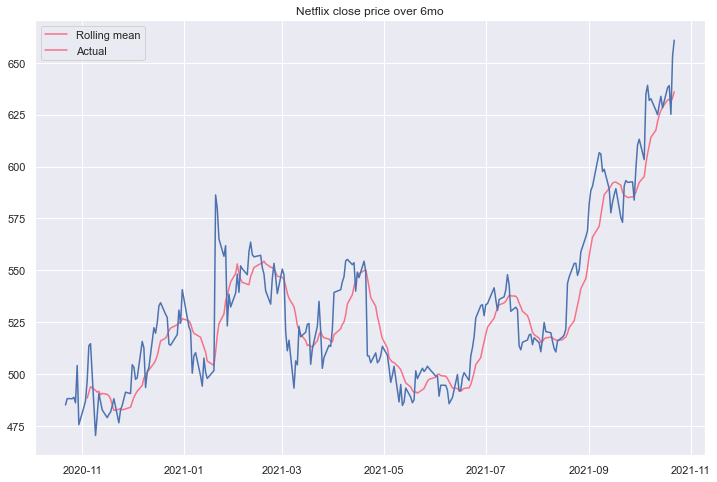

In [11]:
nflx = data[data['symbol'] == 'NFLX'].drop(['symbol', 'shortName', 'sector', 'industry', 'country'], axis=1)
plot_moving_average(nflx, 10, 'Netflix')

C:\Users\maste\Desktop\Сессия осень 2021\Разработка серверных web-приложений\tickers\forecasting\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


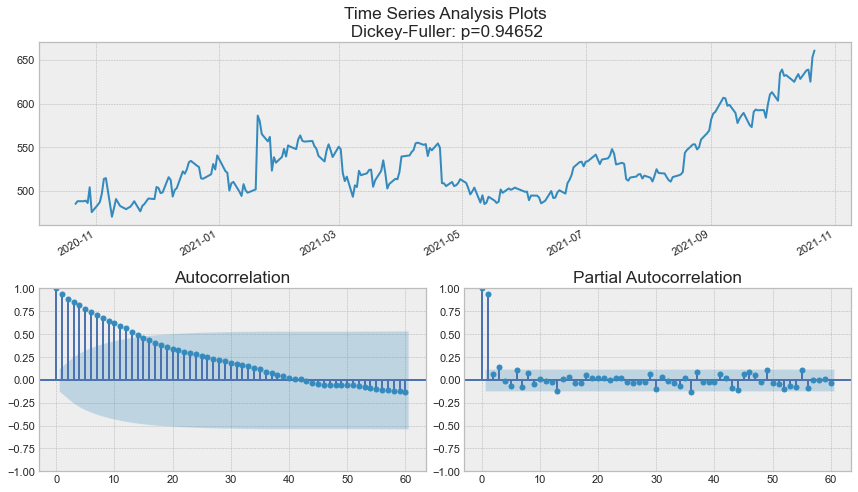

In [12]:
tsplot(nflx.T.iloc[:, 0], lags=60)

Сделаем ряд более стационарным

<AxesSubplot:>

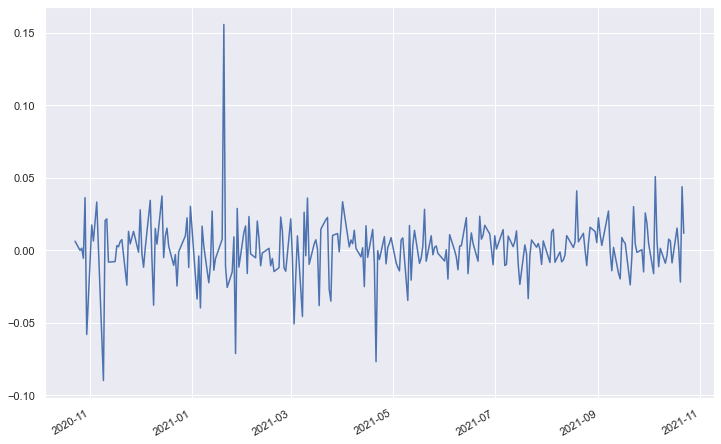

In [13]:
nflx = nflx.T
nflx.columns = ['price']
nflx['log'] = np.log(nflx['price'])
nflx['log_diff'] = nflx['log'] - nflx['log'].shift(1)
nflx['log_diff'].dropna().plot()

C:\Users\maste\Desktop\Сессия осень 2021\Разработка серверных web-приложений\tickers\forecasting\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


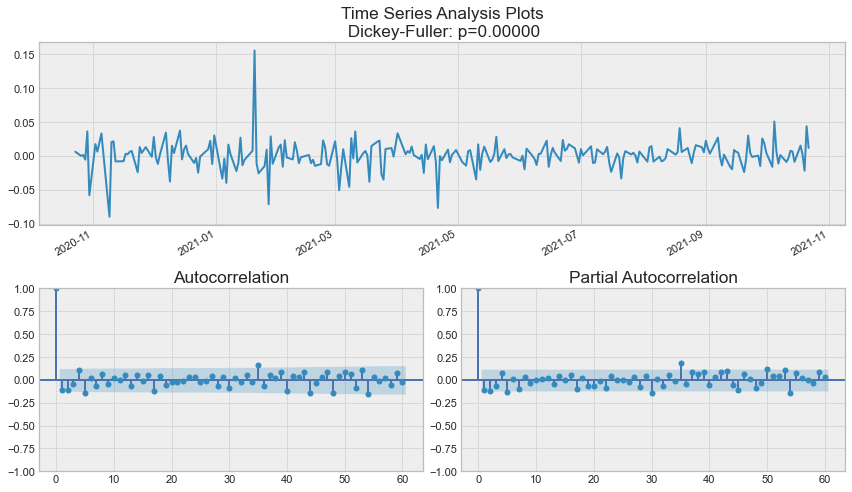

In [14]:
tsplot(nflx['log_diff'].dropna(), lags=60)

### Линейная регрессия + лаги

In [15]:
for i in range(6, 25):
    nflx["lag_{}".format(i)] = nflx['log_diff'].shift(i)

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [18]:
y = nflx.dropna()['log_diff']
X = nflx.dropna().drop(['log_diff', 'log', 'price'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);


def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

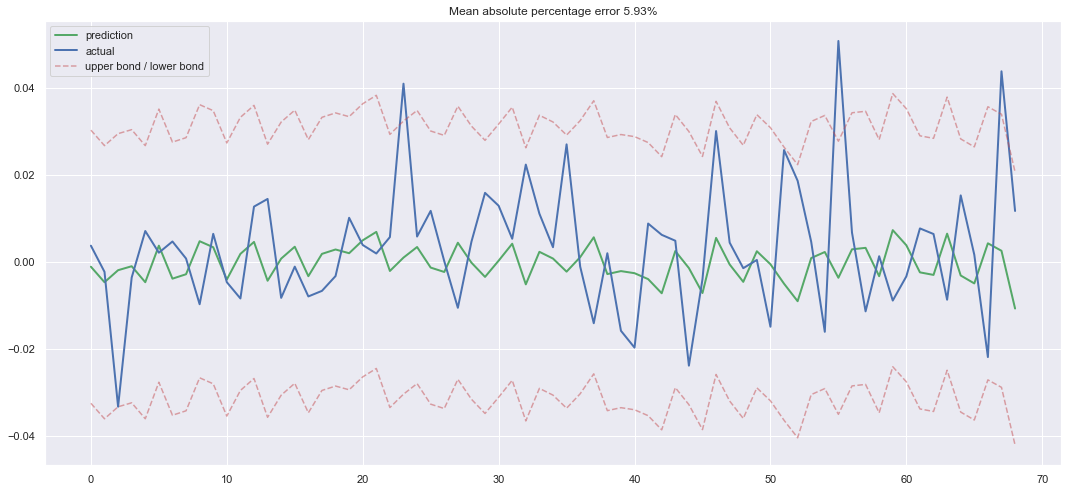

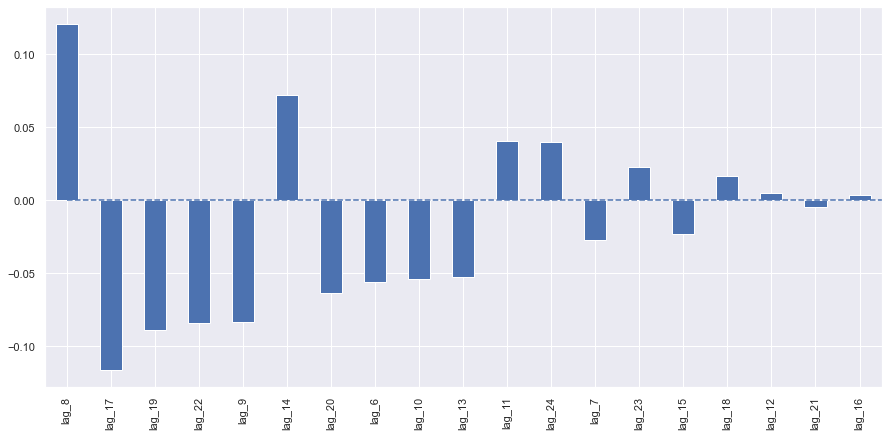

In [21]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [22]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

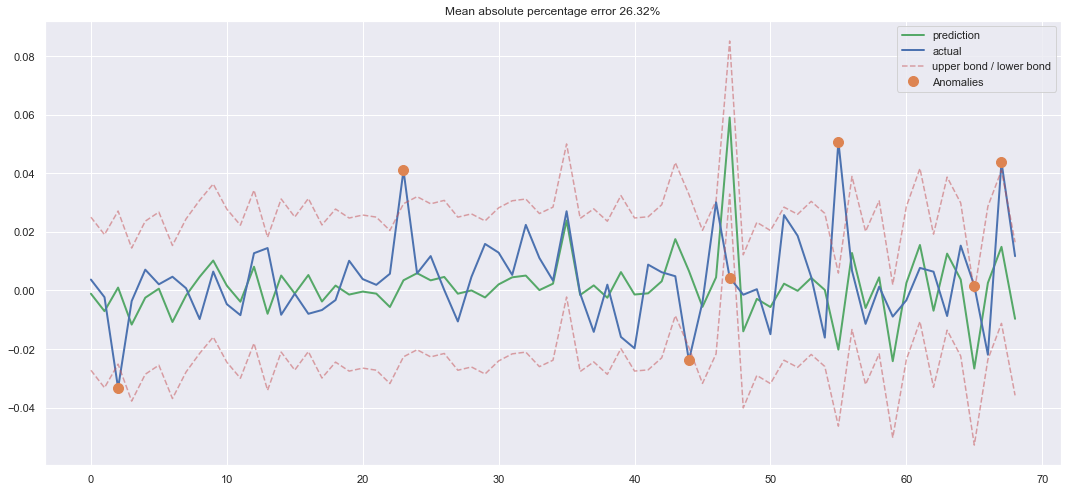

In [23]:
plotModelResults(xgb,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True, plot_anomalies=True)

### TDA

In [129]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import  PersistenceEntropy
from gtda.plotting import plot_point_cloud

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [97]:
window_size = 5
stride = 2

In [130]:
y = nflx.dropna()['log_diff']
X = nflx.dropna().drop(['log_diff', 'log', 'price'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

sliding = SlidingWindow(size=window_size, stride=stride)
X_train, y_train = sliding.fit_transform_resample(X_train, y_train)

embedder = TakensEmbedding(dimension=5, time_delay=2)
X_train = embedder.fit_transform(X_train)

In [133]:
X_train.shape

(78, 11, 25)

In [134]:
nsamples, n_x, n_y = X_train.shape
X_train_2dim = X_train.reshape((nsamples, n_x * n_y))

pca = PCA(n_components=2)
X_train_2dim = pca.fit_transform(X_train_2dim)
plot_point_cloud(X_train_2dim)

In [135]:
vr_persistence = VietorisRipsPersistence()
X_train = vr_persistence.fit_transform(X_train)

In [136]:
vr_persistence.plot(X_train)

In [137]:
p_entropy = PersistenceEntropy()
X_train = p_entropy.fit_transform(X_train)

In [138]:
X_test, y_test = sliding.transform_resample(X_test, y_test)
X_test = embedder.fit_transform(X_test)
X_test = vr_persistence.fit_transform(X_test)
X_test = p_entropy.fit_transform(X_test) #amplitude

In [139]:
clf = RandomForestRegressor(random_state=8)
clf.fit(X_train, y_train)
y_test = pd.Series(y_test)

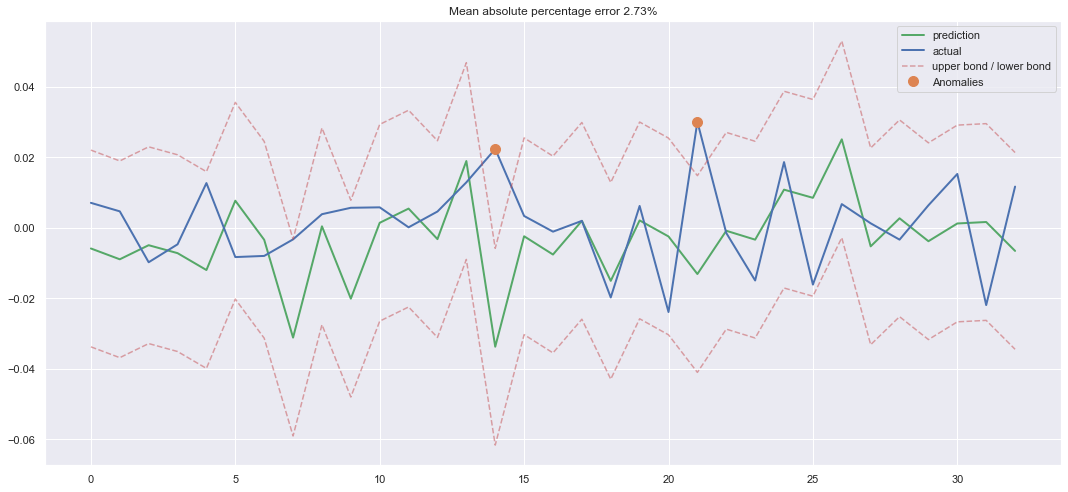

In [140]:
plotModelResults(
    clf,
    X_train=pd.DataFrame(X_train),
    X_test=pd.DataFrame(X_test),
    plot_intervals=True, plot_anomalies=True
)